# Fastai with a Pytorch Training Loop
> Use fastai with a pytorch training loop

- toc: true
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Deep Learning]

This post is inspired by [Zach Mueller's](https://twitter.com/TheZachMueller) blog on [Pytorch to Fastai, Bridging the Gap](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html).  I read that post and thought it was a fantastic illustration of how you can switch out components of fastai with pytorch as needed so you can do low level customization anytime you want.  I am writing this post to expand on Zach's work.

Often a complaint about fastai is "I need access to the training loop and fastai doesn't allow this".   I want to show that that statement is just not true.  Zach's post demonstrated how to use pytorch components in a fastai training loop seamlessly.  This post is going to demonstrate the inverse is also just as easy.  Said another way, this post will demonstrate creating a fastai learner (without any pytorch) and then using that in a pure pytorch training loop. 

Of course, most of the time you would use callbacks to modify the training loop.  But this isn't a fastai requirement and fastai doesn't force you to do so.  There may be some instances where that's not desirable.  For example, I was working with CycleGAN models which has 2 generators and 2 discriminators.  While you could find a way to use callbacks to make that work in the fastai training loop, I found it easier to just have a custom pytorch training loop.  As with every other piece of fastai, switching the fastai bits out for pytorch is seamless so that's no problem.

In [1]:
from fastai.vision.all import *

# Create the Fastai Learner

This section will create everything needed to train a model model.  First, we start with the dataloaders.

In [2]:
# Download data
path = untar_data(URLs.CIFAR)

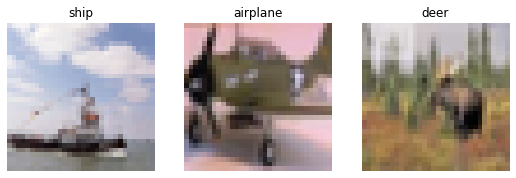

In [3]:
# Create Dataloaders
dls = ImageDataLoaders.from_folder(path,valid_pct=0.2)
dls.show_batch(max_n=3)

Next, we ceate the fastai learner. 

You may notice I am not specifying a scheduler, optimizer, or loss function.  Because of that it will use fastai's defaults.    We'll use all of that fastai goodness in the pytorch training loop.

>Note: Of course, you can specify any of these components more explicitly using fastai.  Or you can swap them out for pure pytorch components as demonstrated in [Zach's blog post](https://muellerzr.github.io/fastblog/2021/02/14/Pytorchtofastai.html). 

In [4]:
learn = cnn_learner(dls,resnet18)

# Training

Great!  We've got all we need to train a model using fastai, but let's do it in pytorch instead.  This code follows the the training loop in the [pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).  For more details check out that tutorial.  Naturally, you can add anything custom here just as you would in pytorch (because what you see below is pytorch).

+ `learn.dls.train` is the fastai train dataloader we defined above.
+ `learn.opt` is the optimizer in the fastai learner.
+ `learn.loss_func` is the loss function in the fastai learner.
+ `learn.model` is the model in the fastai learner.  

All that was defined by fastai above and we can simply call them directly in a pytorch training loop.

>Note: To use the fastai training loop you would do use something like `learn.fine_tune` or `learn.fit_one_cycle`.  This is doing a pytorch training loop instead.

In [5]:
learn.model.to('cuda')

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(learn.dls.train, 0): 
        inputs, labels = data
        
        learn.opt.zero_grad()
        
        outputs = learn.model(inputs)
        loss = learn.loss_func(outputs, labels)
        loss.backward()
        learn.opt.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0        

[1,   100] loss: 1.827
[1,   200] loss: 1.383
[1,   300] loss: 1.247
[1,   400] loss: 1.120
[1,   500] loss: 1.040
[1,   600] loss: 1.010
[1,   700] loss: 0.984
[2,   100] loss: 0.867
[2,   200] loss: 0.899
[2,   300] loss: 0.910
[2,   400] loss: 0.879
[2,   500] loss: 0.860
[2,   600] loss: 0.851
[2,   700] loss: 0.831


# Conclusion

If you need to something custom pure pytorch thing in fastai you can.  It really doesn't matter if that custom thing is in the training loop, dataloaders, optimizers, loss function, or something else - it all integrates with pytorch seamlessly.

For most things I reccomend getting comfortable and using the powerful fastai callback system.  But in situations when you need or want pytorch - go for it!